<h1>Probando la solución a la pregunta: ¿Podemos predecir las cancelaciones?</h1>

In [1]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import modulo_conn_sql as mcq
from io import BytesIO

# Importar Keras y librerias adicionales
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals.joblib import dump, load

import xgboost as xgb
from xgboost import XGBClassifier

import pickle

import sqlalchemy as sa
import urllib

import warnings
warnings.filterwarnings('ignore')

KeyboardInterrupt: 

In [7]:
#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

def ajuste_final(row):
    if row.PotencialCancelacion == 1 and row.volumen_entregado > 0:
        return 1
    elif row.PotencialCancelacion == 0:
        return 0
    else:
        return 0
 

<h2> ---------------------- Preparando el dataset ----------------------- </h2>

In [28]:
#parametros para indicadores de predicción
pais='Colombia'
dias = 15
indice = 1
fecha_target = '2020-11-21'
version_clasificacion = 'n500_3'
nombre_clasificador = 'xgb_prediccion_cancelaciones_n500.pkl'

In [29]:
#Dataset de los despachos
df_serv_pred = querySQL( "{CALL SCAC_AP10_dataset_servicios (?,?)}" , (pais,dias) )
df_serv_pred = df_serv_pred.fillna(value=np.nan)
df_serv_pred['year_month'] = df_serv_pred.FechaEntrega.dt.to_period('M')
#df_serv_pred.head()

#Dataset de la programación
df_pedidos = querySQL( "{CALL SCAC_AP11_Dataset_Pedidos (?,?)}" , (pais, dias) )
df_pedidos = df_pedidos.fillna(value=np.nan)
df_pedidos['year_month'] = df_pedidos.FechaEntrega.dt.to_period('M')
#df_pedidos.head()

#---------- Dataset - Programacion Target --------------------

#programación del día que se quiere analizar
df_target = querySQL( "{CALL SCAC_AP12_Dataset_scacAT15_Programacion (?,?)}" , (pais, fecha_target) )
df_target = df_target.fillna(value=np.nan)
#df_target.head()

# %Cumplimiento por obra
df_cumpto = df_serv_pred[(df_serv_pred['Entrega'] != '') & (df_serv_pred['Estatus'] == 'Normal') ].groupby(['Obra'])['Cumplimiento'].agg(['sum','count']).reset_index()
df_cumpto['cumplimiento_mes'] = df_cumpto['sum'] / df_cumpto['count']
df_cumpto = df_cumpto.drop(['sum','count'], axis=1)

#Tiempo en Obra por obra
df_to = df_serv_pred[(df_serv_pred['Entrega'] != '') & (df_serv_pred['Estatus'] == 'Normal') ].groupby(['Obra'])['TiempoObra'].agg(['mean']).reset_index()
df_to = df_to.rename(columns = {'mean':'tiempo_obra'})

#Volumen Entregado Obra 
df_ve = df_serv_pred[(df_serv_pred['Entrega'] != '') & (df_serv_pred['Estatus'] == 'Normal') ].groupby(['Obra'])['VolPartida'].agg(['sum']).reset_index()
df_ve = df_ve.rename(columns = {'sum':'volumen_entregado'})

#Aceptación de Órdenes por obra
df_ao = df_pedidos.groupby(['Obra'])['AceptacionOrdenes'].agg(['sum', 'count']).reset_index()
df_ao['AO'] = df_ao['sum']/df_ao['count']
df_ao = df_ao.drop(['sum','count'], axis= 1)

#Cancelación motivo cliente por obra
df_canc = pd.pivot_table(
    df_pedidos,
    index = ['Obra'],
    values = ['VolCanceladoCliente', 'VolPartida'],
    aggfunc = np.sum
)
df_canc = df_canc.reset_index()
df_canc['cancelacionCliente'] =df_canc['VolCanceladoCliente']/df_canc['VolPartida']
df_canc = df_canc.drop(['VolCanceladoCliente', 'VolPartida'], axis= 1)

#------------Productividad Programación------------------

#Volumen pedido dia
df_target_info_pedidos = df_target[(df_target['PedidoCancelado']== 0) & (df_target['EstatusPedido'] != 'Por confirmar - Cabecera')].groupby(['Obra'])['VolPartida'].agg('sum').reset_index()
df_target_info_pedidos['VolumenDia'] = df_target_info_pedidos['VolPartida']
df_target_info_pedidos= df_target_info_pedidos.drop(['VolPartida'], axis=1)
# Numero de pedidos en la fecha target
df_pdo = df_target.groupby(['Obra'])['Pedido'].agg(['count']).reset_index()
df_pdo.rename(columns={'count':'PedidosDia'}, inplace = True)
#Pedidos (No Cancelados) Mensuales por obra
df_pmo = df_pedidos[df_pedidos['PedidoCancelado'] == 0].groupby(['Obra'])['Pedido'].agg(['count']).reset_index()
df_pmo.rename(columns={'count':'PedidosMes'}, inplace = True)

In [30]:
#Se ensamblan los indicadores
#Se agrega indicador cumplimiento mes obra
df = pd.merge(df_target, df_cumpto, how='left', on=['Obra'] )
#Se agrega indicador Tiempo en obra 
df = pd.merge(df, df_to, how='left', on=['Obra'] )
#Se agrega volumen entregado mes obra 
df = pd.merge(df, df_ve, how='left', on=['Obra'] )
#Se agrega aceptacion de ordenes por obra por mes 
df = pd.merge(df, df_ao, how='left', on=['Obra'] )
#Se agrega cancelacion motivo cliente por obra por mes 
df = pd.merge(df, df_canc, how='left', on=['Obra'] )
#se agrega numero de pedidos (no cancelados) solicitados en el mes 
df = pd.merge(df, df_pmo, how='left', on=['Obra'] )

#se agrega pedidos solicitados por obra el dia target
df = pd.merge(df, df_pdo, how='left', on=['Obra'] )
#se agrega volumen total entregado por obra el dia target
df = pd.merge(df, df_target_info_pedidos, how='left', on=['Obra'] )

#calular productividad programacion diaria
df['productividad_programacion'] =( ( (df['VolumenDia'] * (1 - df['cancelacionCliente']) * indice ) / df['PedidosDia']) / (df['volumen_entregado']/df['PedidosMes'])).fillna(0)
#df.head(100)

#df_noCancelado = df[df['PedidoCancelado']==0]

df_noCancelado = df
#tomo unicamente las columnas que son variables predictoras y  la columna objetivo (pedido cancelado)
dataset = df_noCancelado[[
    'VolPartida',
    'latitud',
    'longitud',
    'DistanciaPlantaObraKm',
    'HoraEntregaPartida',
    'diasCreado',
    'AceptacionOrdenes',
    'DiaSemana',
    'Semana_Relativa',
    'Tremie',
    'Outinord',
    'Bomba',
    'Cimentacion',
    'cumplimiento_mes',
    'AO',
    'tiempo_obra',
    'cancelacionCliente',
    'volumen_entregado',
    'productividad_programacion',
    'PedidoCancelado'
]]

#dataset.head()


#----------------------------------------------------------------------------------------
#---------------------- Ejecución del modelo de clasificación ---------------------------
#----------------------------------------------------------------------------------------



# load model
#______________XGBOOST_______________________
#file_name = "xgb_prediccion_cancelaciones.pkl"
xgb_model_loaded = pickle.load(open(nombre_clasificador, "rb"))

#importar escalador
sc=load('std_scaler.bin')

#definicion de X, y para el modelo de clasificacion 
X = dataset[[
    'VolPartida',
    'latitud',
    'longitud',
    'DistanciaPlantaObraKm',
    'HoraEntregaPartida',
    'diasCreado',
    'AceptacionOrdenes',
    'DiaSemana',
    'Semana_Relativa',
    'Tremie',
    'Outinord',
    'Bomba',
    'Cimentacion',
    'cumplimiento_mes',
    'AO',
    'tiempo_obra',
    'cancelacionCliente',
    'volumen_entregado',
    'productividad_programacion'
]].fillna(0)

#Escalado de variables con el mismo escalador con que se realizo el entrenamiento del modelo
X_pred = sc.transform(X)
# Predicción de los resultados con el Conjunto de Testing
y_pred  = xgb_model_loaded.predict(X_pred)

#Transformacion(trasponer matriz) y concatenacion del resultado
y_pred = pd.DataFrame([y_pred]).T
y_pred.rename(columns = {0:'PotencialCancelacion'}, inplace = True)
df_noCancelado= df_noCancelado.reset_index()
df_result = pd.concat([df_noCancelado, y_pred], axis= 1)
#se crea una columna version (que es la informacion de fecha y hora actual) para identificar el momento en que se realizó la prediccion
df_result['version'] = (pd.to_datetime("now") - datetime.timedelta(minutes = 300)).strftime("%Y-%m-%d %H:%M:%S")

#ajuste final - aun en validacion
#df_result['PotencialCancelacion'] = df_result.apply(ajuste_final, axis=1)

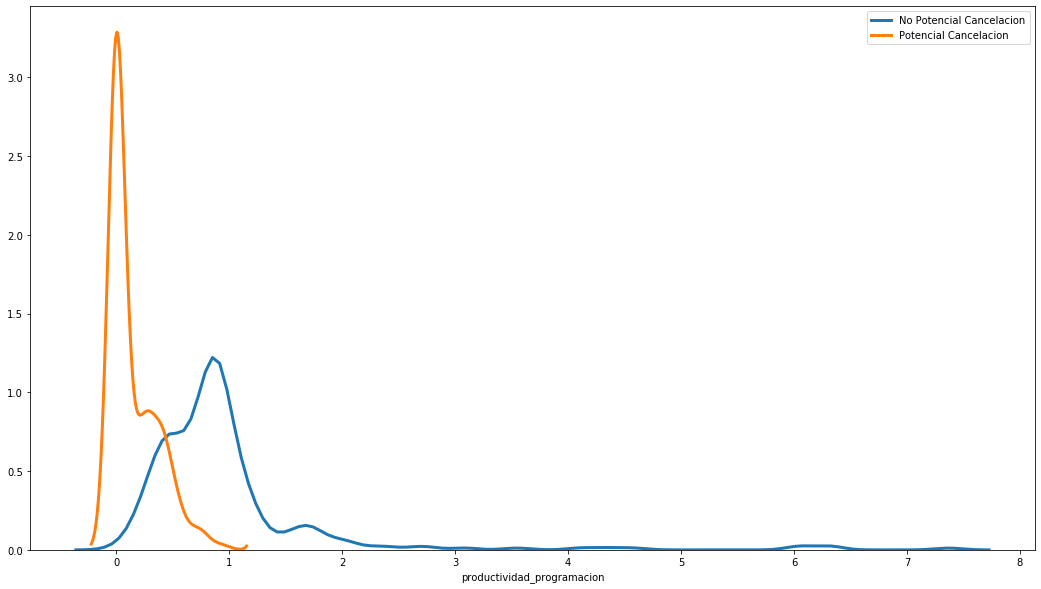

In [31]:
plt.figure(figsize=(18,10))

sns.distplot( df_result[ (df_result['PotencialCancelacion']== 0 ) ]['productividad_programacion'], hist = False, kde = True, kde_kws = {'linewidth': 3}, label = 'No Potencial Cancelacion')
sns.distplot( df_result[ (df_result['PotencialCancelacion']== 1 ) ]['productividad_programacion'], hist = False, kde = True, kde_kws = {'linewidth': 3}, label = 'Potencial Cancelacion')

In [32]:
#Solo numero de pedido, version y resultado de la clasificacion
df_result = df_result[['Pedido','version', 'PotencialCancelacion']]



#exportar potenciales cancelaciones a Excel
"""
output= BytesIO()
writer = pd.ExcelWriter(output, engine='xlsxwriter')
writer = pd.ExcelWriter("resultados/results_" + fecha_target + "_"  + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S") + "J4.xlsx", engine="xlsxwriter")
df_result.to_excel(writer)
writer.save()
"""

#arreglar el dataframe y guardar en SQL
df_toSql = df_result
df_toSql.rename(columns = {'version':'FechaClasificacion','PotencialCancelacion':'Clasificacion' }, inplace = True)
df_toSql['Version'] = version_clasificacion
df_toSql = df_toSql[['Pedido', 'FechaClasificacion', 'Version', 'Clasificacion']]

params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=COOCCAPP11A;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

df_toSql.to_sql("SCAC_AT34_ResultadosClasificacionCancelaciones", engine, index=False, if_exists="append", schema="dbo")